## Importing Libraries -

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
import os
import matplotlib.pyplot as plt

In [2]:
# Looking up tensorflow version
print('tensorflow', tf.__version__)

tensorflow 2.11.0


## Loading data -

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory ("data/Alzheimer_s Dataset/train",
                                                                validation_split=0.2, subset='training', seed=42)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory ("data/Alzheimer_s Dataset/train",
                                                             validation_split=0.2, subset='validation', seed=42)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory ("data/Alzheimer_s Dataset/test", seed=42)

Found 1279 files belonging to 4 classes.


## Looking at the data -

In [6]:
classnames = train_ds.class_names
classnames

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [7]:
NUM_IMAGES = []

for label in classnames:
    dir_name = "data/Alzheimer_s Dataset/train/" + label[:-2] +'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))
    
NUM_IMAGES,classnames

([717, 52, 2560, 1792],
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

## Data Viz -

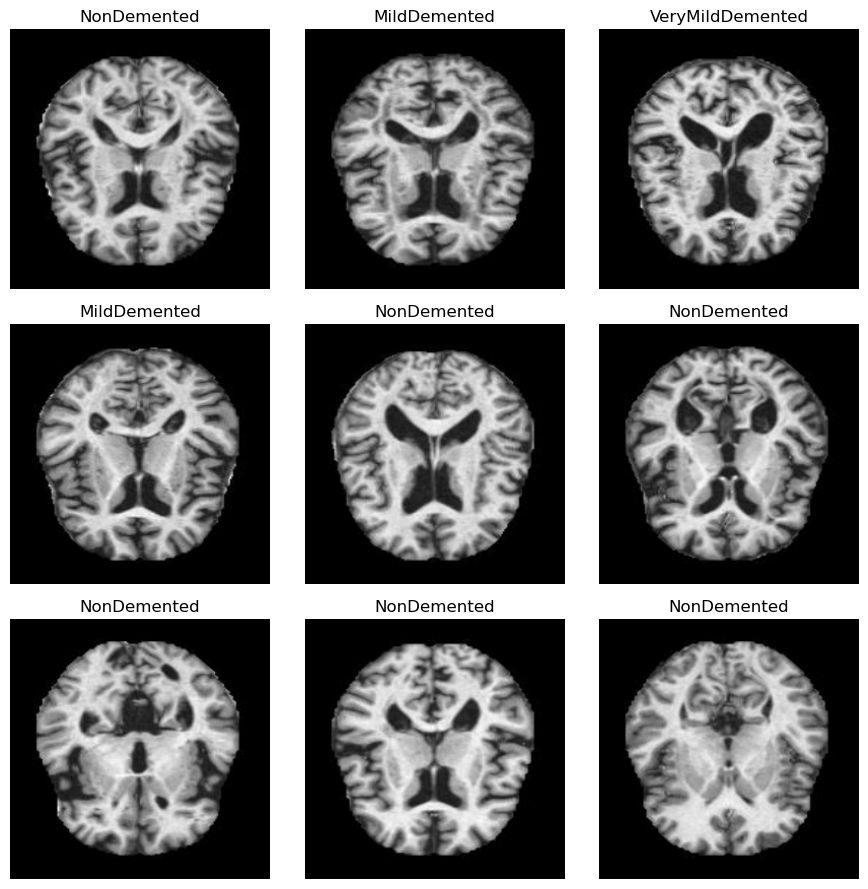

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))

for images, labels in train_ds.take(1):
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(train_ds.class_names[labels[i]])
        ax.axis("off")
plt.tight_layout()
plt.show()

## Feature Engineering -

Feature engineering involves transforming features in a way that makes them more understandable to the model. When working with categorical and noncontinuous data, one approach is to use one-hot encodings. This technique helps the model differentiate between categorical and continuous data, allowing for more accurate analysis.

In [9]:
def one_hot_label(image, label):
    label = tf.one_hot(label, len(classnames))
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Building ML Model

In [15]:
# Define a function that creates a convolutional block.
# The block applies two separable convolutional layers with the same number of filters and a kernel size of 3x3,
# using the ReLU activation function and 'same' padding.
# It also includes a batch normalization layer and a max pooling layer.

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [16]:
# Define a function that creates a dense block.
# The block applies a dense layer with the specified number of units and the ReLU activation function,
# followed by a batch normalization layer and a dropout layer with the specified dropout rate.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [22]:
# Define a function that builds a convolutional neural network model.
# The model consists of a series of convolutional blocks, followed by several dense blocks and a final output layer
# with a softmax activation function to produce the class probabilities.

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        # Apply two convolutional layers with 16 filters and a kernel size of 3x3, using ReLU activation and 'same' padding.
        tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
        
        # Apply a max pooling layer to reduce the spatial dimensions by a factor of 2.
        tf.keras.layers.MaxPool2D(),
        
        # Apply several convolutional blocks with increasing numbers of filters.
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        # Add dropout layers with a rate of 0.2 to prevent overfitting.
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        
        # Add another dropout layer with a rate of 0.2.
        tf.keras.layers.Dropout(0.2),
        
        # Flatten the output of the convolutional layers.
        tf.keras.layers.Flatten(),
        
        # Apply several dense blocks with decreasing numbers of units and increasing dropout rates.
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        # Apply a final dense layer with the number of units equal to the number of classes,
        # using softmax activation to produce class probabilities.
        tf.keras.layers.Dense(len(classnames), activation='softmax')
    ])
    
    return model

In [23]:
strategy = tf.distribute.MirroredStrategy()
IMAGE_SIZE = [176, 208]

# Build the model within the scope of the strategy
with strategy.scope():
    model = build_model()

    # Define the evaluation metric(s)
    evaluation_metrics = [tf.keras.metrics.AUC(name='auc')]

    # Configure the model for training with the specified optimizer and loss function
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=evaluation_metrics
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## Training the model

In [25]:
# Define a learning rate scheduler based on exponential decay
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

# Set the initial learning rate and decay rate for the learning rate scheduler
initial_lr = 0.01
decay_rate = 20

# Create a learning rate scheduler function based on exponential decay
exponential_decay_fn = exponential_decay(initial_lr, decay_rate)

# Define a callback to adjust the learning rate based on the scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Define a callback to save the best model during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

# Define a callback to stop training early if there is no improvement in the validation loss for a certain number of epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [28]:
# Define input image dimensions
IMG_WIDTH = 176
IMG_HEIGHT = 208

# Load and preprocess the data
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/100


ValueError: in user code:

    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\josec\anaconda3\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 4)).
